In [1]:
from source.spinsystem import SpinSystem
from source.utils import reconstruct_grid, visualize_grid, plot_array_list
from datetime import datetime
import numpy as np
from numpy import empty, nan, savetxt
from sys import argv

In [2]:
MAX_FILE_SIZE = 100_000

def read_config_file(filename):
    config = {}
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            key, value = line.split("=")
            config[key.strip()] = value.strip()
    return config

config_filename = "multising.conf"
config = read_config_file(config_filename)

In [3]:
# Paramètres
grid_height = int(config["grid_height"])
grid_width  = int(config["grid_width"])
alpha       = float(config["alpha"])
j           = float(config["j"])
total_updates = int(config["total_updates"])
init_up     = float(config["init_up"])
beta        = float(config["beta"])

reduced_alpha              = -2 * beta * alpha
reduced_neighbour_coupling = -2 * beta * j

# On stocke la magnétisation
magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan

# Instancie le système
spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up
)

In [4]:
full_grids = []
full_grid = reconstruct_grid(spin_system.black, spin_system.white)  # On fusionne
full_grids.append(full_grid)

In [5]:
total_updates = 100
full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))

for ii in range(total_updates):
    # Mise à jour
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    # Sauvegarde tous les MAX_FILE_SIZE
    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

# Sauvegarde finale
savetxt(f"magnetisation_{ii}.dat", magnetisation)

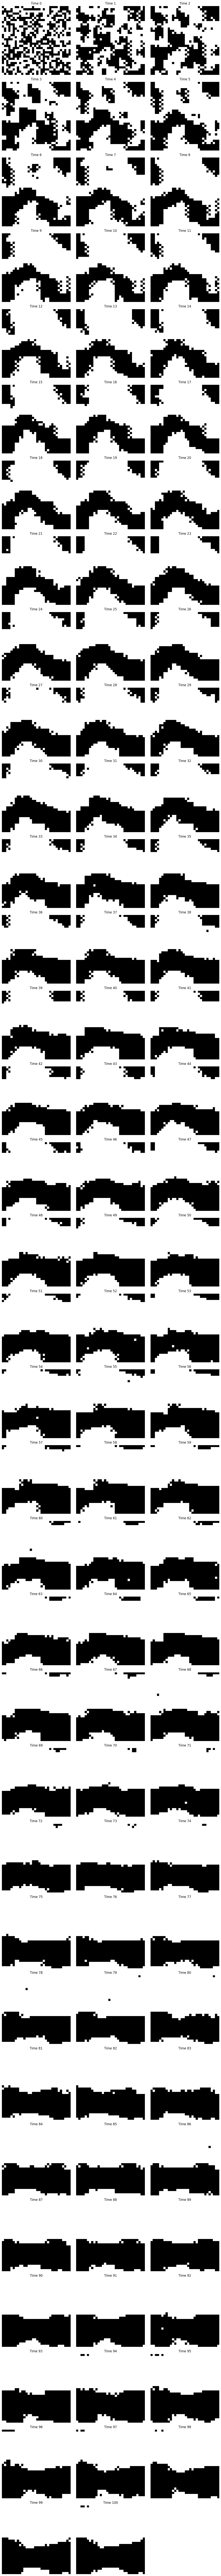

In [6]:
plot_array_list(full_grids, max_cols=3)

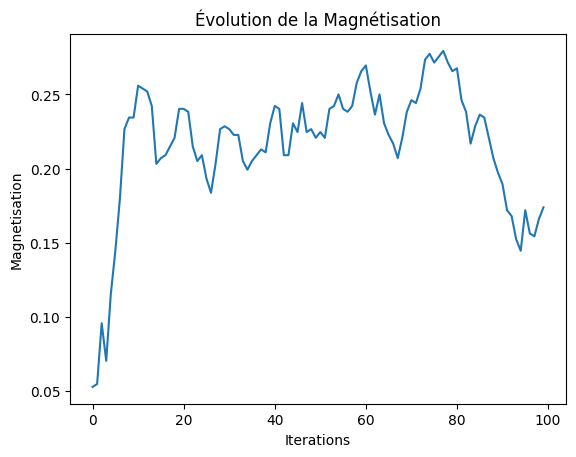

In [7]:
import matplotlib.pyplot as plt
plt.plot(magnetisation)
plt.xlabel("Iterations")
plt.ylabel("Magnetisation")
plt.title("Évolution de la Magnétisation")
plt.show()